- Inputs
    - PSPS Report Processing, Duration of events:  Dec 2020 - Jan 2021
        - 2 months of data
        - 3 events
    - CIMIS Weather Station Data
        - 200 Weather Stations
        - 13 readings from the weather station:  wind, humidity, temp, etc.
        - Total records:  230k, 1 hour each
- Outputs
    - How can it be used?
        - Ex. Next 5 days, low fire risk at weather stations x,y,z with prob %
        - Forecasting Humidity, Wind
        - Predicting "crossings", extreme values, negative correlations of humidity and wind
    - What metrics do we have?
- Methods
    1. Preprocessing
        - Document reading/table extraction for PSPS data
        - During PSPS event, extreme wind/humidity values were observed

    2. Processing
        - Get weather station data from APIs (CIMIS, MesoWest, etc.)
        - Join/match data sources based on time

    3. Prediction
        - Built a prediction model to anticipate extreme wind/humidity
        
    4. Model Building
        - Technical details of inputs, wind distribution, simplicity of predicting humidity, temp
        - Technology, Software, Algorithms:  Gluon-ts
        - How is the model built?  Layers, Tuning
        - Performance, Accuracy:  Time to train per config, metrics
        - Potential pitfalls, challenges, failures
        
    5. Future Enhancements
        - Train model on morning data only
        - Domain knowledge, constraints on humidity, wind
        - Data feed morning/evening.  How to handle new data?
        - Input from metereology to improve/tune models

    6. Results
        - Temp, Humid, Wind Prediction Accuracy
        - Relationship between wind/humidity, wind brings humidity down, increasing fire risk
        - 3-day and 7-day forecast (how long do PSPS events last for?  what granularity do we need?)
            - 4, 6-hour intervals, find chance of PSPS events in each interval
            - Distill data/predictions into clear visualizations
        
    7. Reuseability
        - Demand Forecasting
        - Use cases:  Energy and Utilities, Load shedding

Deadline:  
    - PPT on 31st
    - Inform Shubam on presentation to Nia team on June 3rd
    - Inform Sreeraj on meeting on June 4th
    - Raji to contact Dash after these, for June 8-10
  
Further Investigation
- Lottery Ticket Hypothesis, Network pruning, adjust weights based on new data, knowledge distillation
- Rather than predicting magntiude, predicting derivatives may be easier
- Oct/Nov Data

In [535]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
from collections import defaultdict, Counter
from itertools import chain, starmap

In [536]:
source = pd.read_csv("../data/source.csv", parse_dates=["start", "end"])

In [537]:
wr = pd.read_csv("../data/weather/weather_report_DecJan.csv", parse_dates=["Date"])
wr = wr[~wr.duplicated()]

In [538]:
wr["Hour"] = pd.Timedelta('1h') * wr["Hour"]/100

In [539]:
wr["Time"] = wr["Date"] + wr["Hour"]

<AxesSubplot:>

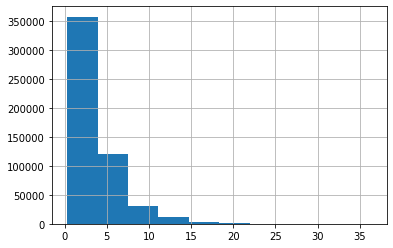

In [540]:
wind_speed = wr["HlyWindSpd (MPH)"]
wind_speed[wind_speed < 100].hist()

### Start/End Dates for Dec-Jan PSPS Events

In [541]:
se_dates = source[["start", "end"]]
se_dates = se_dates[~se_dates.duplicated()].sort_values(by="start").reset_index(drop=True)
se_dates.iloc[6:]

,start,end
6,2020-12-04,2020-12-14
7,2020-12-16,2020-12-24
8,2021-01-12,2021-01-21


### Matching Notifications of PSPS Event by County against CIMIS Data

In [542]:
notifications = pd.read_csv("../data/2021/deenergization_2021.csv", parse_dates=True)
ws = pd.read_csv("../data/weather/weather_stations.csv", parse_dates=True)

notif_by_county = notifications.County.value_counts().sort_values()
notif_by_county = notif_by_county

counties = []
for county in notif_by_county.index:
     for c in county.split(";"):
            counties.append(c.title())

psps_county_stations = ws[ws.County.isin(counties)].StationNbr

len(set(counties)), len(psps_county_stations.values)

(9, 102)

In [64]:
wind_max = wr[wr.Station.isin(psps_county_stations.values)][["Station", "HlyWindSpd (MPH)"]].groupby("Station").max()
wind_max = wind_max[(wind_max > 25) & (wind_max < 60)].dropna()
wind_max

,HlyWindSpd (MPH)
Station,
125,30.6
197,29.5
204,28.0
234,26.1


### When do Wind Speed and Humidity achieve max/min values, respectively

In [543]:
crossings = wr[(wr["HlyWindSpd (MPH)"] > wr["HlyRelHum (%)"]) & (wr["HlyRelHum (%)"] > 0)]
crossings.head()

,Date,Julian,Hour,Station,Standard,ZipCodes,Scope,HlyAirTmp (F),HlyDewPnt (F),HlyEto (in),...,HlyAsceEtr (in),HlyPrecip (in),HlyRelHum (%),HlyResWind (MPH),HlySoilTmp (F),HlySolRad (Ly/day),HlyVapPres (mBars),HlyWindDir (°),HlyWindSpd (MPH),Time
14825,2019-01-20,20,18:00:00,41,english,"92281, 92257, 92233",hourly,58.1,-36.9,0.00,...,NaN,0.0,1.0,2.7,45.2,1.0,0.2,132.0,2.8,2019-01-20 18:00:00
14834,2019-01-21,21,03:00:00,41,english,"92281, 92257, 92233",hourly,61.7,-8.9,0.00,...,NaN,0.0,5.0,7.1,45.0,0.0,1.0,263.0,8.3,2019-01-21 03:00:00
14835,2019-01-21,21,04:00:00,41,english,"92281, 92257, 92233",hourly,62.9,-26.7,0.01,...,NaN,0.0,2.0,9.6,44.8,0.0,0.4,265.0,11.4,2019-01-21 04:00:00
14847,2019-01-21,21,16:00:00,41,english,"92281, 92257, 92233",hourly,67.8,-5.1,0.01,...,NaN,0.0,5.0,13.2,45.7,537.0,1.2,294.0,13.6,2019-01-21 16:00:00
14854,2019-01-21,21,23:00:00,41,english,"92281, 92257, 92233",hourly,49.9,-36.9,0.00,...,NaN,0.0,2.0,2.1,46.3,0.0,0.2,276.0,2.9,2019-01-21 23:00:00


In [544]:
crossings.Date.value_counts().sort_index().loc["2021-01-17":"2021-01-20"]

2021-01-17     25
2021-01-18    115
2021-01-19    118
Name: Date, dtype: int64

In [545]:
station_crossings = crossings[(crossings.Date >= "2021-01-17") & (crossings.Date <= "2021-01-20")].Station.value_counts().sort_values(ascending=False)
station_crossings.head()

204    24
198    15
6      15
125    12
215    12
Name: Station, dtype: int64

In [546]:
station_crossings.index

Int64Index([204, 198,   6, 125, 215, 243, 139, 121, 217, 222, 152, 211, 247,
            140, 220, 262, 103,  88, 226, 221, 256, 212, 242, 206,  92,  91,
            129, 160, 144, 235, 248, 257, 187, 143, 254,  77, 116,  84,  70,
            228,  62, 224, 209, 253, 191],
           dtype='int64')

In [231]:
crossings[(crossings.Station == 44)].sort_values("Date").tail()

,Date,Julian,Hour,Station,Standard,ZipCodes,Scope,HlyAirTmp (F),HlyDewPnt (F),HlyEto (in),...,HlyAsceEtr (in),HlyPrecip (in),HlyRelHum (%),HlyResWind (MPH),HlySoilTmp (F),HlySolRad (Ly/day),HlyVapPres (mBars),HlyWindDir (°),HlyWindSpd (MPH),Time
326174,2021-01-15,15,15:00:00,44,english,"92522, 92521, 92519, 92518, 92517, 92516, 9251...",hourly,83.6,15.1,0.02,...,NaN,0.0,8.0,10.5,52.5,913.0,3.0,5.0,10.6,2021-01-15 15:00:00
326175,2021-01-15,15,16:00:00,44,english,"92522, 92521, 92519, 92518, 92517, 92516, 9251...",hourly,83.2,14.1,0.01,...,NaN,0.0,7.0,7.7,52.9,560.0,2.9,7.0,8.0,2021-01-15 16:00:00
326198,2021-01-16,16,15:00:00,44,english,"92522, 92521, 92519, 92518, 92517, 92516, 9251...",hourly,83.5,26.1,0.02,...,NaN,0.0,12.0,11.8,52.7,865.0,4.8,5.0,12.4,2021-01-16 15:00:00
326196,2021-01-16,16,13:00:00,44,english,"92522, 92521, 92519, 92518, 92517, 92516, 9251...",hourly,82.3,25.5,0.02,...,NaN,0.0,12.0,13.8,51.9,1303.0,4.7,8.0,14.0,2021-01-16 13:00:00
326199,2021-01-16,16,16:00:00,44,english,"92522, 92521, 92519, 92518, 92517, 92516, 9251...",hourly,81.9,25.2,0.01,...,NaN,0.0,12.0,12.8,53.1,520.0,4.6,2.0,13.0,2021-01-16 16:00:00


### Visualizations by Station

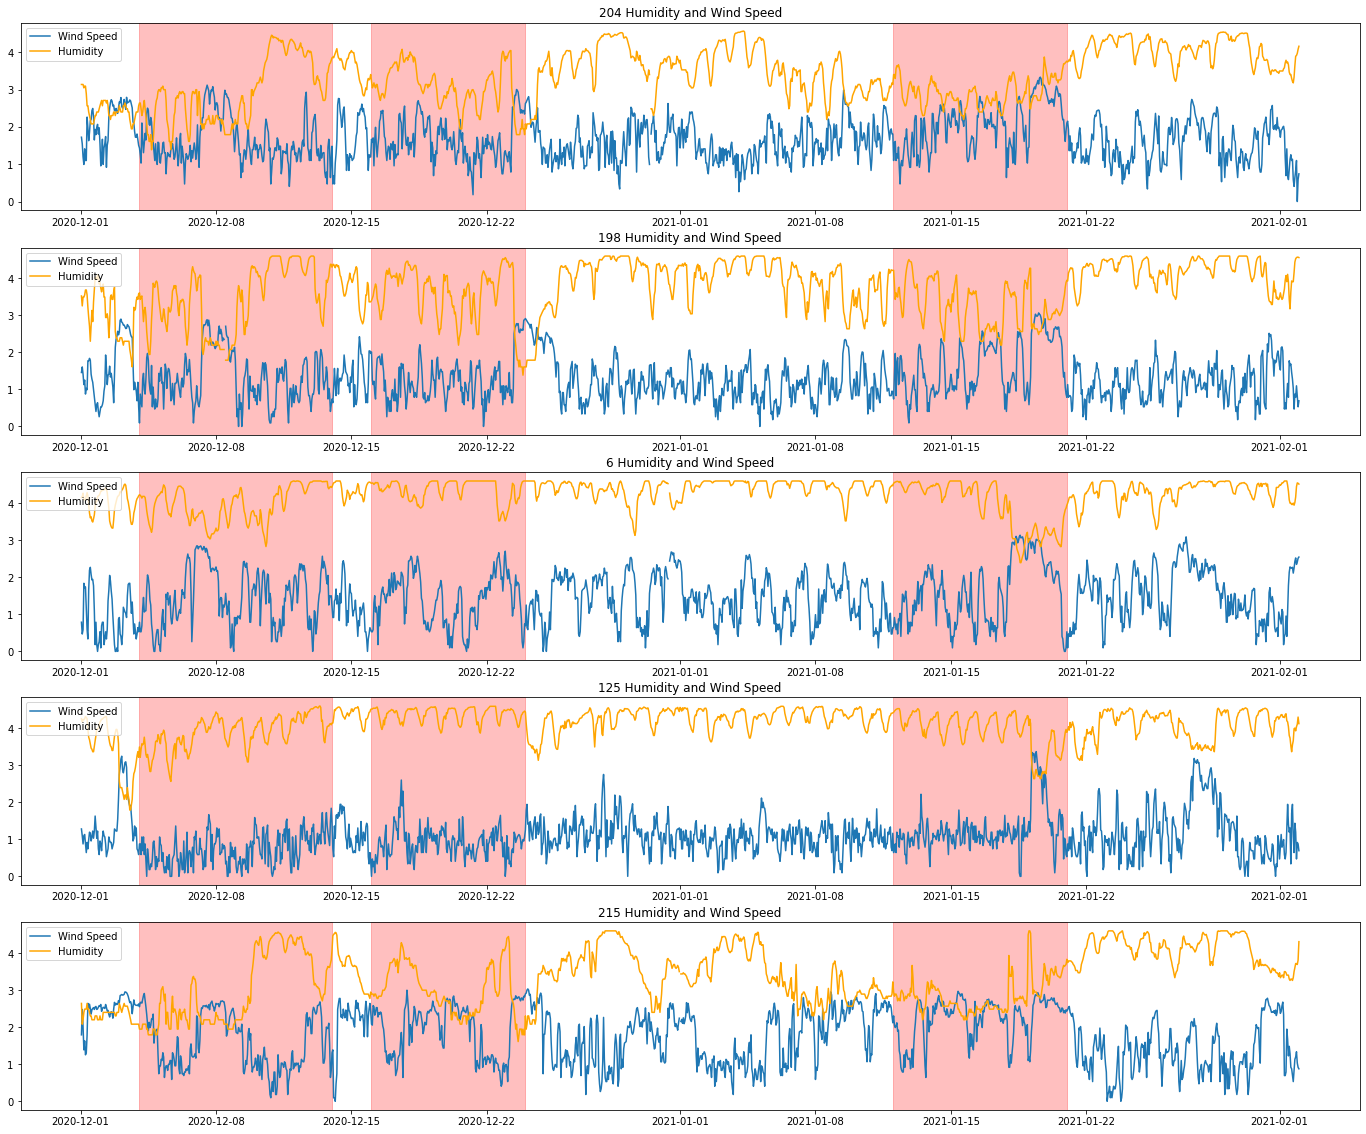

In [547]:
stations = station_crossings.head().index
dates = se_dates.iloc[6:]
fig, ax = plt.subplots(len(stations), 1,figsize=(24,20))
for (s, v_ax) in zip(stations, ax):
        wrs = wr[(wr.Station==s) & (wr.Date >= "2020-12-01")]
        wrs.set_index("Time", inplace=True)
        
        # For a single date range, narrow plot to that range
        if len(dates.index) == 2:
            wrs = wrs.loc[dates.start:dates.end]
            
        v_ax.plot(np.log(wrs["HlyWindSpd (MPH)"]), label="Wind Speed")
        
        v_ax.plot(np.log(wrs["HlyRelHum (%)"]), color="orange", label="Humidity")
        v_ax.set_title("{} Humidity and Wind Speed".format(s))
        
        # For multiple date ranges, highlight relevant time
        if len(dates.index) > 2:
            for (start, end) in dates.values:
                v_ax.axvspan(start, end, color='red', alpha=0.25)

        v_ax.legend(loc="upper left")
#         v_ax[1].hist(wrs["HlyWindSpd (MPH)"].diff(), bins=30)
#         v_ax[1].set_title("{} Wind Speed Increments".format(s))
            
#         v_ax[3].hist(wrs["HlyRelHum (%)"].diff(), bins=30)
#         v_ax[3].set_title("{} Humidity".format(s))


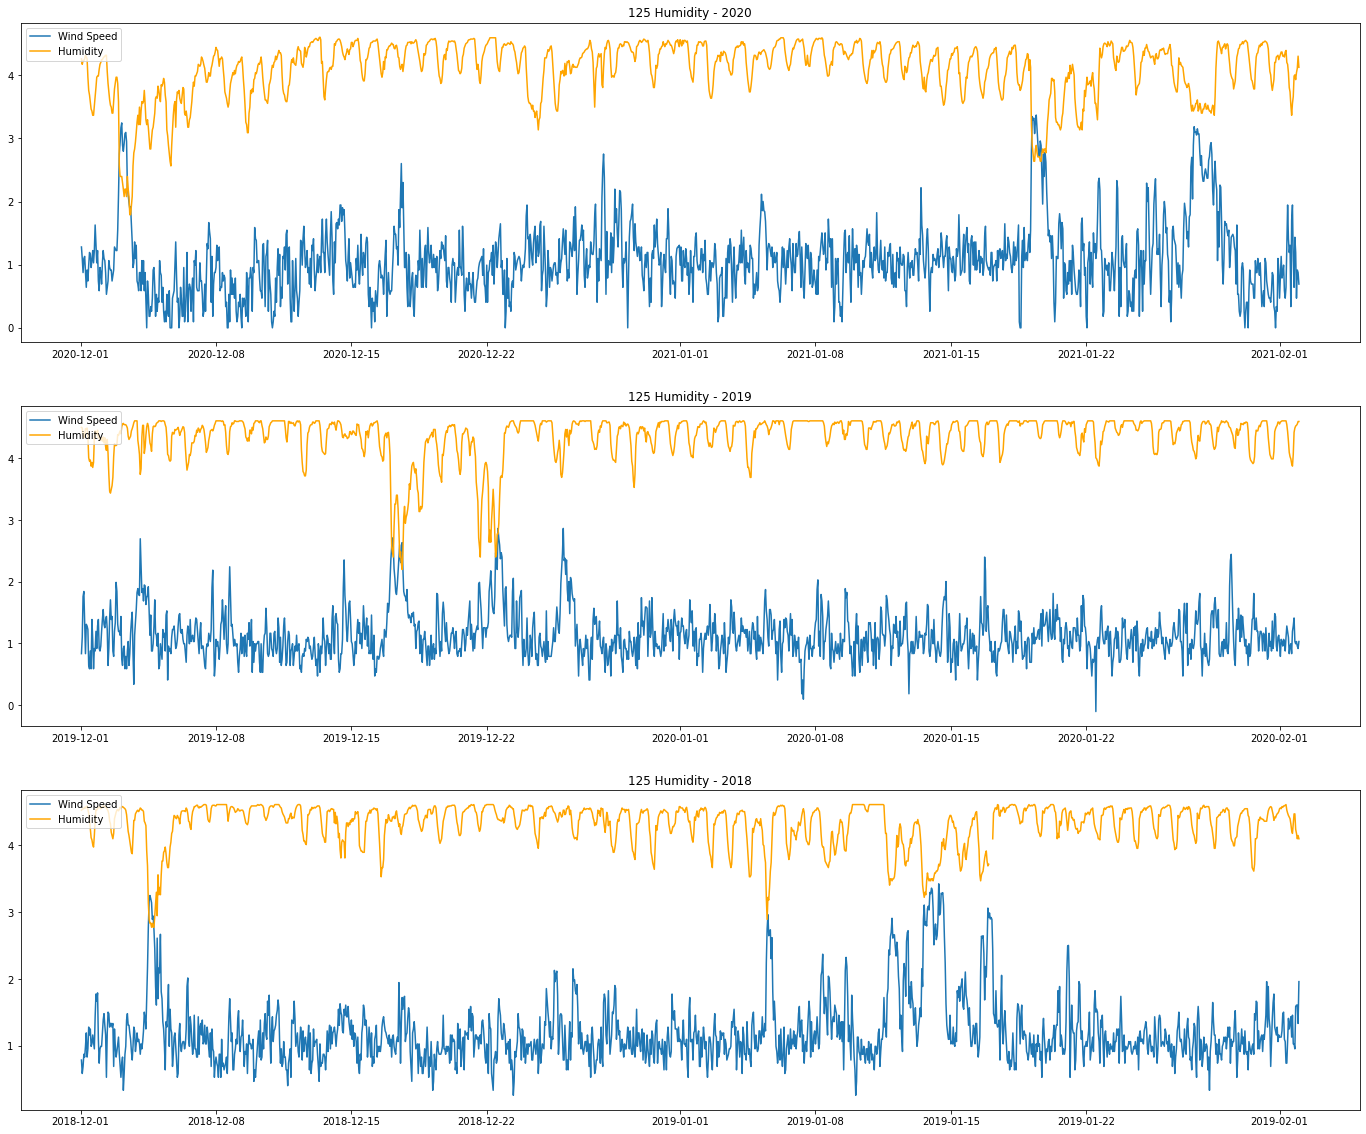

In [14]:
s = 125
wrs = wr[(wr.Station==s)].set_index("Time")

two_months = pd.Timedelta("62d")

fig, ax = plt.subplots(3, 1,figsize=(24,20))
for (year, v_ax) in zip(["2020", "2019", "2018"], ax): 
        start = pd.Timestamp("{}-12-01".format(year))
        end = start + two_months
    
        v_ax.plot(np.log(wrs.loc[(wrs.Date >= start) & (wrs.Date <= end),"HlyWindSpd (MPH)"]), label="Wind Speed")
        
        v_ax.plot(np.log(wrs.loc[(wrs.Date >= start) & (wrs.Date <= end),"HlyRelHum (%)"]), color="orange", label="Humidity")
        v_ax.set_title("{} Humidity - {}".format(s, year))
        
        # For multiple date ranges, highlight relevant time
#         v_ax.axvspan("{}-12-01".format(year), "2021-01-21", color='red', alpha=0.25)

        v_ax.legend(loc="upper left")
#         v_ax[1].hist(wrs["HlyWindSpd (MPH)"].diff(), bins=30)
#         v_ax[1].set_title("{} Wind Speed Increments".format(s))
            
#         v_ax[3].hist(wrs["HlyRelHum (%)"].diff(), bins=30)
#         v_ax[3].set_title("{} Humidity".format(s))


## GlutonTS

In [65]:
from gluonts.model.predictor import Predictor
from gluonts.evaluation import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator

In [66]:
from gluonts.mx.distribution.gamma import GammaOutput
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.canonical import CanonicalRNNEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deep_factor import DeepFactorEstimator # Not working?  NaN loss in most epochs
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.mx.trainer import Trainer

In [558]:
#(wr.Date.dt.year >= 2020) & (wr.Date.dt.month >= 12) & (wr.Station.isin(psps_county_stations.values))
wr_gts = wr.copy()
wr_gts.set_index("Time", inplace=True)
# wr_gts = wr_gts[wr_gts.columns[(wr_gts.columns.str.contains("Hly")) | (wr_gts.columns.str.contains("Station"))]]

In [559]:
target_columns = wr_gts.columns[wr_gts.columns.str.contains("Hly")]

keys = []
targets = []
for (key, df) in wr_gts.groupby(["Station", pd.Grouper(freq='1AS-DEC')]):
        tss = df[target_columns].transpose().iterrows()
        for (c, ts) in tss:
            targets.append(ts)
            keys.append((*key, c))

In [ ]:
target_dict = {key:target for (key, target) in zip(keys, targets)}

In [560]:
# By default, take up to 3 days before event
training_data = ListDataset(
    [{"start": df.index[0], "target": df.loc[:"2021-01-17 00:00:00"]} for df in targets],
    freq = "60min"
)

training_data_3day = training_data

# 2018-2020 Jan only
training_data_year = ListDataset(
    [{"start": df.index[0], "target": df.loc[:"2020-02-01 00:00:00"]} for (key, df) in zip(keys, targets) if key[1].year < 2020],
    freq = "60min"
)

# 1 week out from PSPS event
training_data_week = ListDataset(
    [{"start": df.index[0], "target": df.loc[:"2021-01-13 00:00:00"]} for df in targets],
    freq = "60min"
)

### Model Parameters
- model = Deep AR Estimator
- all   = 2018-2021 Dec-Jan 17th Data
- year  = 2018, 2019 Dec-Jan Data only
- e     = epochs
- L     = Layers
- CL    = Context Length (default = prediction_length)

### Models
- model-initial:  2021 data only
- model-all-e100-2L
- model-all-e100-4L
- model-all-e20-4L-30CL:  Worst performance.  Assumed due to long context length
- model-all-e20-4L-7CL:  Better compared to 30CL, but still bad.  
- model-all-e100-20L: Trained on all data
- model-2021-e100-20L:  Trained on 2019/20 and 2020/21 Dec-Jan data, best performance yet in most cases?
- model-year-e100-20L:  Trained on 2018 - Feb 2020 data only

In [563]:
estimator = DeepAREstimator(freq="60min", prediction_length=24*7, trainer=Trainer(epochs=100, batch_size=32), num_layers=8)
# estimator = DeepFactorEstimator(freq="60min", prediction_length=24*3, trainer=Trainer(epochs=100, learning_rate=.00001))

### Train a new model...

In [564]:
predictor = estimator.train(training_data=training_data)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:59<00:00,  1.20s/it, epoch=100/100, avg_epoch_loss=0.0732]


In [565]:
predictor.serialize(Path("../models/model-all-e100-8L-7d"))

### ...or load an existing one!

In [86]:
os.listdir("../models")

['.DS_Store',
 'model-2020-e100-20L',
 'model-ws-e100-20L.csv',
 'model-ws-e100-20L',
 'model-all-factor',
 'model-all-e100-20L-new',
 'model-year-e100-20L',
 'model-all-e100-20L']

In [87]:
predictor = Predictor.deserialize(Path("../models/model-all-e100-20L-new"))

### Visualize Predictions

In [567]:
wr_test = wr_gts[(wr_gts.Station==204) & (wr_gts.Date.dt.year==2021)]
# wr_test.set_index("Time", inplace=True)
wr_test = wr_test[target_columns]

test_data = ListDataset(
    [{"start": wr_test.index[0], "target": wr_test.loc[:"2021-01-20 00:00:00", c]} for c in target_columns],
    freq = "60min"
)

test_data_3day = test_data

test_data_week = ListDataset(
    [{"start": wr_test.index[0], "target": wr_test.loc[:"2021-01-24 00:00:00", c]} for c in target_columns],
    freq = "60min"
)

In [568]:
sforecast_it, sts_it = make_evaluation_predictions(
    dataset=test_data_week,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [569]:
sforecasts = list(sforecast_it)
stss = list(sts_it)

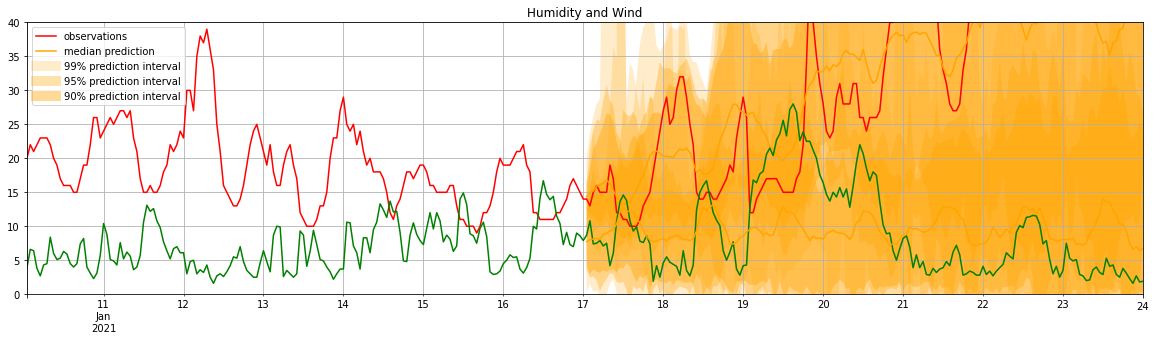

In [573]:
plot_length = 2*7*24
prediction_intervals = [90,95,99]
legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

fig, ax = plt.subplots(1, 1, figsize=(20, 5))

# Humidity
# i = 7
# stss[i][-plot_length:].plot(ax=ax, color="red")  # plot the time series
# sforecasts[i].plot(prediction_intervals=prediction_intervals, color='orange')

# Wind
i = 13
stss[i][-plot_length:].plot(ax=ax, color="green")  # plot the time series
sforecasts[i].plot(prediction_intervals=prediction_intervals, color='orange')

#ax.set_xbound("2021-01-17", "2021-01-19")
ax.set_ybound(0,40)
plt.title("Humidity and Wind")
plt.grid(which="both")
plt.legend(legend, loc="upper left")
plt.show()

### Compute metrics

In [139]:
# metrics = []
# for s in psps_county_stations.values:
#     wr_test = wr_gts[(wr_gts.Station==s) & (wr_gts.Date.dt.year==2021)]
#     wr_test = wr_test[target_columns]
    
#     if len(wr_test.index) == 0:
#         continue
    
#     metric = {}
#     metric["station"] = s

#     test_data = ListDataset(
#         [{"start": wr_test.index[0], "target": wr_test.loc[:"2021-01-20 00:00:00", c]} for c in target_columns],
#         freq = "60min"
#     )

#     forecast_it, ts_it = make_evaluation_predictions(
#         dataset=test_data,  # test dataset
#         predictor=predictor,  # predictor
#         num_samples=100,  # number of sample paths we want for evaluation
#     )
    
#     forecasts = list(forecast_it)
#     tss = list(ts_it)
    
#     for i in range(14):
#         metric[target_columns[i]] = sum(tss[i][-int(plot_length/2):].values.reshape(-1) < forecasts[i].quantile(.99))/(plot_length/2)
        
#     metrics.append(metric)


In [110]:
test_keys = [key for key in keys if key[1].year == 2020 and key[2] in target_columns[[0,7,13]]]
all_test_data = ListDataset(
    [{"start": target_dict[key].index[0], "target": target_dict[key].loc[:"2021-01-20 00:00:00"]} for key in test_keys],
    freq = "60min"
)

all_test_data_3day = all_test_data

all_test_data_week = ll_test_data = ListDataset(
    [{"start": target_dict[key].index[0], "target": target_dict[key].loc[:"2021-01-24 00:00:00"]} for key in test_keys],
    freq = "60min"
)

In [111]:
forecast_all_it, ts_all_it = make_evaluation_predictions(
    dataset=all_test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=500,  # number of sample paths we want for evaluation
)
forecasts = list(forecast_all_it)
tss = list(ts_all_it)

In [151]:
print(len(forecasts), len(tss), len(test_keys))

453 453 453


#### Metric Computations:  % with 99th Percentile

In [152]:
metrics = defaultdict(dict)
for (k, f, ts) in zip(test_keys, forecasts, tss):
    metrics[k[0]][k[2]] = sum(ts[-int(plot_length/2):].values.reshape(-1) < f.quantile(.99))/(plot_length/2)

In [154]:
metricsdf = pd.DataFrame(metrics).transpose().sort_index()
metricsdf.head()

,HlyAirTmp (F),HlyRelHum (%),HlyWindSpd (MPH)
2,1.000000,1.0,1.000000
5,1.000000,1.0,1.000000
6,0.972222,1.0,0.652778
7,1.000000,1.0,1.000000
12,0.888889,1.0,1.000000


In [161]:
metricsdf.mean()

HlyAirTmp (F)       0.965692
HlyRelHum (%)       0.972958
HlyWindSpd (MPH)    0.926233
dtype: float64

In [532]:
# metricsdf.to_csv("../data/metrics/metrics_all_new.csv")

#### Metric Computations:  Crossings

In [207]:
crossings_forecast = {}
for i in range(int(len(test_keys)/3)):
    crossings_forecast[test_keys[3*i][0]] = (forecasts[3*i+1].samples < forecasts[3*i+2].samples).any(axis=1).mean()
crossings_forecast_series = pd.Series(crossings_forecast)

In [574]:
crossings_forecast_series.sort_values().describe(percentiles=np.arange(0,1,.1))

NameError: name 'crossings_forecast_series' is not defined

In [209]:
crossings_forecast_df = pd.DataFrame([crossings_forecast_series, station_crossings]).transpose()
crossings_forecast_df.columns = ["Prob of Crossing", "Actual Crossing Count"]
crossings_forecast_df.fillna(0, inplace=True)

In [240]:
crossings_forecast_df[crossings_forecast_df["Prob of Crossing"] > .33].sort_values("Prob of Crossing")

,Prob of Crossing,Actual Crossing Count
35,0.338,0.0
199,0.342,0.0
218,0.354,0.0
150,0.364,0.0
136,0.372,0.0
239,0.410,0.0
208,0.428,0.0
256,0.444,5.0
216,0.462,0.0
159,0.470,0.0


#### Metric Analysis

In [581]:
metrics_dict = {}
for s in os.listdir("../data/metrics"):
    if s.endswith(".csv"):
        metrics_dict[s[:-4]] = pd.read_csv("../data/metrics/" + s).mean(axis=0)
metrics_dict.keys()

dict_keys(['metrics_all_4L', 'metrics_all', 'metrics_all_10L', 'metrics_year'])

In [583]:
all_metrics = pd.DataFrame(metrics_dict)
all_metrics.drop("Unnamed: 0", axis=0, inplace=True)
all_metrics[all_metrics.columns.sort_values(ascending=True)]

,metrics_all,metrics_all_10L,metrics_all_4L,metrics_year
HlyAirTmp (F),0.968175,0.912160,0.942329,0.959069
HlyRelHum (%),0.974062,0.939478,0.888337,0.976729
HlyWindSpd (MPH),0.925497,0.892476,0.651950,0.834437


- What is the floating precision of the model parameters?  8?  32?
- How about 10 layers?
- What about minimum thresholds, cutting off low wind values?  Exclude evening values, train on day's values

In [168]:
metricsdf_new = pd.read_csv("../data/metrics/metrics_all_new.csv").set_index("Unnamed: 0")
metricsdf_new.loc[204]

HlyAirTmp (F)       1.000000
HlyRelHum (%)       1.000000
HlyWindSpd (MPH)    0.916667
Name: 204, dtype: float64

### Gluon-ts Metrics

In [109]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9, 0.95, 0.99])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(all_test_data))

Running evaluation:   0%|          | 0/2114 [00:00<?, ?it/s]


AssertionError: fcst_iterator has more elements than ts_iterator

In [534]:
import json
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 455.155715776307,
    "abs_error": 370047.1286582947,
    "abs_target_sum": 1142880.8021697998,
    "abs_target_mean": 35.64187502791929,
    "seasonal_error": 2.3608032068857594,
    "MASE": 4.579675688116553,
    "MAPE": 0.5234505508231453,
    "sMAPE": 0.42281178081968485,
    "OWA": NaN,
    "MSIS": 53.36099800347841,
    "QuantileLoss[0.1]": 303808.1908961373,
    "Coverage[0.1]": 0.15420011086265153,
    "QuantileLoss[0.5]": 370047.126193732,
    "Coverage[0.5]": 0.4235142916742077,
    "QuantileLoss[0.9]": 178499.44358956214,
    "Coverage[0.9]": 0.781207163722171,
    "QuantileLoss[0.95]": 114453.01796626452,
    "Coverage[0.95]": 0.8586979418308154,
    "QuantileLoss[0.99]": 34134.91473160031,
    "Coverage[0.99]": 0.9705513449252879,
    "RMSE": 21.334378729560115,
    "NRMSE": 0.5985762172402067,
    "ND": 0.323784534621412,
    "wQuantileLoss[0.1]": 0.2658266639174853,
    "wQuantileLoss[0.5]": 0.32378453246496436,
    "wQuantileLoss[0.9]": 0.1561837798400976,


In [ ]:
print(json.dumps(item_metrics, indent=4))